<a href="https://www.kaggle.com/code/dataranch/exports-model-comparison-feature-importance?scriptVersionId=108678162" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**FMCG Export Stats Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

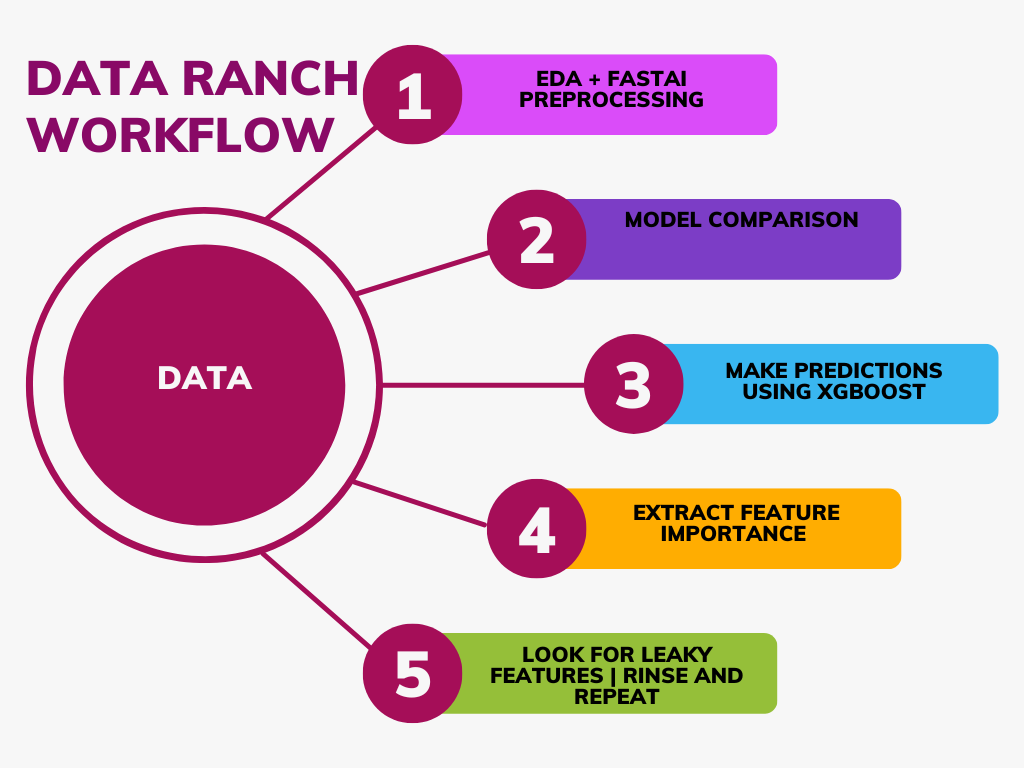

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.2 MB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'fmcg-export-sale'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 3000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = False
SEP_COMMA = True
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/fmcg-export-sale
CSV!


In [12]:
df

,ID,Date,Category,Invoice Number,Product Code,Customer Code,Destenation,QTY,Total Price
0,2529604,2019-04-28,Category5,267,30011006,612,IRQ,750,3334.82
1,2529605,2019-04-29,Category5,302,30011006,514,BHR,400,3032.82
2,2529606,2019-05-13,Category5,507,30011006,513,BHR,100,749.95
3,2529607,2019-06-01,Category5,795,30011006,5,SYC,100,556.82
4,2529608,2019-07-03,Category5,1184,30011006,560,AFG,20,39.45
...,...,...,...,...,...,...,...,...,...
2995,2532599,2021-03-15,Category2,52,30001339,21,IRQ,70,786.84
2996,2532600,2021-03-15,Category2,52,30001342,21,IRQ,70,887.29
2997,2532601,2021-03-15,Category2,52,30001341,21,IRQ,70,887.29
2998,2532602,2021-03-15,Category2,52,30001340,21,IRQ,70,887.29


In [13]:
if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_no_dollar'] = df[col + '_no_dollar'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')


if SEP_COMMA:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string() or ',' in df[col].to_string():
            df[col + '_processed'] = df[col].str.replace('%', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_processed'] = df[col + '_processed'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')

In [14]:
df

,ID,Date,Category,Invoice Number,Product Code,Customer Code,Destenation,QTY,Total Price
0,2529604,2019-04-28,Category5,267,30011006,612,IRQ,750,3334.82
1,2529605,2019-04-29,Category5,302,30011006,514,BHR,400,3032.82
2,2529606,2019-05-13,Category5,507,30011006,513,BHR,100,749.95
3,2529607,2019-06-01,Category5,795,30011006,5,SYC,100,556.82
4,2529608,2019-07-03,Category5,1184,30011006,560,AFG,20,39.45
...,...,...,...,...,...,...,...,...,...
2995,2532599,2021-03-15,Category2,52,30001339,21,IRQ,70,786.84
2996,2532600,2021-03-15,Category2,52,30001342,21,IRQ,70,887.29
2997,2532601,2021-03-15,Category2,52,30001341,21,IRQ,70,887.29
2998,2532602,2021-03-15,Category2,52,30001340,21,IRQ,70,887.29


In [15]:
df.rename(columns={'Destenation': 'Destination'}, inplace=True)

In [16]:
df.isna().sum()

ID                0
Date              0
Category          0
Invoice Number    0
Product Code      0
Customer Code     0
Destination       0
QTY               0
Total Price       0
dtype: int64

In [17]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

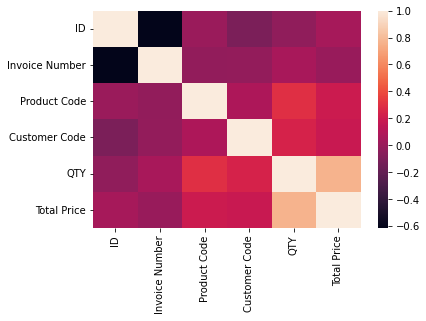

In [18]:
sns.heatmap(df.corr())

In [19]:
df.head().style.background_gradient(cmap = "inferno")

,ID,Date,Category,Invoice Number,Product Code,Customer Code,Destination,QTY,Total Price
0,2529604,2019-04-28,Category5,267,30011006,612,IRQ,750,3334.82
1,2529605,2019-04-29,Category5,302,30011006,514,BHR,400,3032.82
2,2529606,2019-05-13,Category5,507,30011006,513,BHR,100,749.95
3,2529607,2019-06-01,Category5,795,30011006,5,SYC,100,556.82
4,2529608,2019-07-03,Category5,1184,30011006,560,AFG,20,39.45


In [20]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
ID,3000.00,2531103.50,866.17,2529604.00,2530353.75,2531103.50,2531853.25,2532603.00
Invoice Number,3000.00,2180.68,1759.73,1.00,49.00,2521.00,3696.25,4871.00
Product Code,3000.00,30003485.02,3123.33,30001036.00,30001269.00,30001338.00,30006003.00,30011023.00
Customer Code,3000.00,206.97,269.29,2.00,7.00,19.00,560.00,612.00
QTY,3000.00,279.74,594.13,1.00,25.00,60.00,200.00,5493.00
Total Price,3000.00,1580.19,2942.53,0.00,233.53,535.02,1494.95,45370.46


In [21]:
df.columns

Index(['ID', 'Date', 'Category', 'Invoice Number', 'Product Code',
       'Customer Code', 'Destination', 'QTY', 'Total Price'],
      dtype='object')

In [22]:
#Remove features we don't want to predict or train on
unwanted_features = ['ID', 'Date', 'Invoice Number', 'Product Code', 'Customer Code']
try:
    for feature in unwanted_features:
        del(df[feature])
except Exception:
    pass

Target Variable: Total Price
CATS=====================
['Category', 'Destination']
CONTS=====================
['QTY']
3
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['QTY']
Categorical variables that made the cut : ['Category', 'Destination']
Tabular Object size: 1232


 10%|▉         | 4/42 [00:00<00:01, 36.47it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.6103715231476856, 'Adjusted R-Squared': 0.6055414180627395, 'RMSE': 2813.247848137537, 'Time taken': 0.039478302001953125}
{'Model': 'BaggingRegressor', 'R-Squared': 0.6757762279645452, 'Adjusted R-Squared': 0.6717569250054279, 'RMSE': 2566.28613175163, 'Time taken': 0.0343327522277832}
{'Model': 'BayesianRidge', 'R-Squared': 0.5051069450542802, 'Adjusted R-Squared': 0.4989719071830523, 'RMSE': 3170.57718066153, 'Time taken': 0.025252819061279297}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.5752276060029186, 'Adjusted R-Squared': 0.5699618325236159, 'RMSE': 2937.3844540194095, 'Time taken': 0.010353565216064453}
{'Model': 'DummyRegressor', 'R-Squared': -0.0022588389135658193, 'Adjusted R-Squared': -0.014683535263734004, 'RMSE': 4512.036, 'Time taken': 0.010128498077392578}
{'Model': 'ElasticNet', 'R-Squared': 0.41888856235683813, 'Adjusted R-Squared': 0.4116847015596088, 'RMSE': 3435.6772703791994, 'Time taken': 0.010549545288085938}


 21%|██▏       | 9/42 [00:00<00:01, 22.75it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.6598625180514408, 'Adjusted R-Squared': 0.6556459376967065, 'RMSE': 2628.511588888557, 'Time taken': 0.1760239601135254}
{'Model': 'GammaRegressor', 'R-Squared': 0.30623193657356085, 'Adjusted R-Squared': 0.2976315060352165, 'RMSE': 3753.9613933501796, 'Time taken': 0.012588977813720703}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -5034.736602403434, 'Adjusted R-Squared': -5097.163089210088, 'RMSE': 319826.2846260951, 'Time taken': 0.16629791259765625}


 29%|██▊       | 12/42 [00:00<00:01, 15.12it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.7257493434796147, 'Adjusted R-Squared': 0.7223495419525026, 'RMSE': 2360.2417481356433, 'Time taken': 0.1391301155090332}


 40%|████      | 17/42 [00:01<00:01, 13.02it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.656114804926198, 'Adjusted R-Squared': 0.651851765317845, 'RMSE': 2642.9526920878684, 'Time taken': 0.3407931327819824}
{'Model': 'HuberRegressor', 'R-Squared': 0.448332496056562, 'Adjusted R-Squared': 0.4414936427018913, 'RMSE': 3347.5059009008196, 'Time taken': 0.017371177673339844}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.6507078102491677, 'Adjusted R-Squared': 0.6463777417811821, 'RMSE': 2663.6497, 'Time taken': 0.011233806610107422}
{'Model': 'KernelRidge', 'R-Squared': 0.20554495806308493, 'Adjusted R-Squared': 0.19569634184072637, 'RMSE': 4017.143194272701, 'Time taken': 0.08423781394958496}
{'Model': 'Lars', 'R-Squared': 0.5053728450610022, 'Adjusted R-Squared': 0.49924110347084927, 'RMSE': 3169.7253099829554, 'Time taken': 0.03335976600646973}
{'Model': 'LarsCV', 'R-Squared': 0.5053728450610022, 'Adjusted R-Squared': 0.49924110347084927, 'RMSE': 3169.7253099829554, 'Time taken': 0.030681610107421875}


 48%|████▊     | 20/42 [00:01<00:01, 15.13it/s]

{'Model': 'Lasso', 'R-Squared': 0.50531136089434, 'Adjusted R-Squared': 0.49917885710377397, 'RMSE': 3169.922308733754, 'Time taken': 0.03357720375061035}
{'Model': 'LassoCV', 'R-Squared': 0.5051913119555806, 'Adjusted R-Squared': 0.49905731995503, 'RMSE': 3170.306917045451, 'Time taken': 0.06466436386108398}
{'Model': 'LassoLars', 'R-Squared': 0.5033156236355134, 'Adjusted R-Squared': 0.4971583793004164, 'RMSE': 3176.3101290413247, 'Time taken': 0.011048078536987305}
{'Model': 'LassoLarsCV', 'R-Squared': 0.5053728450610022, 'Adjusted R-Squared': 0.49924110347084927, 'RMSE': 3169.7253099829554, 'Time taken': 0.015096902847290039}
{'Model': 'LassoLarsIC', 'R-Squared': 0.5053728450610022, 'Adjusted R-Squared': 0.49924110347084927, 'RMSE': 3169.7253099829554, 'Time taken': 0.01028132438659668}
{'Model': 'LinearRegression', 'R-Squared': 0.505372845061002, 'Adjusted R-Squared': 0.49924110347084905, 'RMSE': 3169.725309982956, 'Time taken': 0.008900165557861328}
{'Model': 'LinearSVR', 'R-Squa

 67%|██████▋   | 28/42 [00:02<00:01,  7.24it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.20029005738947014, 'Adjusted R-Squared': -0.2151696862000836, 'RMSE': 4937.71198737522, 'Time taken': 1.4180896282196045}
{'Model': 'NuSVR', 'R-Squared': -0.04327698487137965, 'Adjusted R-Squared': -0.05621017063424816, 'RMSE': 4603.439749007321, 'Time taken': 0.12682819366455078}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.49239467939504644, 'Adjusted R-Squared': 0.4861020514536627, 'RMSE': 3211.0401270128186, 'Time taken': 0.009048700332641602}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.5053728450610022, 'Adjusted R-Squared': 0.49924110347084927, 'RMSE': 3169.7253099829554, 'Time taken': 0.014623641967773438}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.44980992699762923, 'Adjusted R-Squared': 0.44298938890255846, 'RMSE': 3343.0203869834527, 'Time taken': 0.012075662612915039}
{'Model': 'PoissonRegressor', 'R-Squared': 0.31920845402149267, 'Adjusted R-Squared': 0.3107688894019244, 'RMSE': 3718.6878688322868, '

 76%|███████▌  | 32/42 [00:28<00:23,  2.34s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.1345977218141987, 'Adjusted R-Squared': -0.1486629828284245, 'RMSE': 4800.689346292605, 'Time taken': 25.649927854537964}
{'Model': 'RANSACRegressor', 'R-Squared': 0.3736623560727562, 'Adjusted R-Squared': 0.3658978398257242, 'RMSE': 3566.8669285777905, 'Time taken': 0.08664441108703613}


 90%|█████████ | 38/42 [00:29<00:04,  1.22s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.6964540327574453, 'Adjusted R-Squared': 0.6926910662213805, 'RMSE': 2483.10385237657, 'Time taken': 0.22602486610412598}
{'Model': 'Ridge', 'R-Squared': 0.5052322552643885, 'Adjusted R-Squared': 0.49909877082551724, 'RMSE': 3170.1757496432547, 'Time taken': 0.009582757949829102}
{'Model': 'RidgeCV', 'R-Squared': 0.5052322552644253, 'Adjusted R-Squared': 0.4990987708255544, 'RMSE': 3170.175749643137, 'Time taken': 0.00955343246459961}
{'Model': 'SGDRegressor', 'R-Squared': 0.505194914891361, 'Adjusted R-Squared': 0.4990609675553035, 'RMSE': 3170.2953747733613, 'Time taken': 0.009883880615234375}
{'Model': 'SVR', 'R-Squared': -0.12039846611947991, 'Adjusted R-Squared': -0.1342877033027794, 'RMSE': 4770.554951167538, 'Time taken': 0.07251596450805664}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.505372845061002, 'Adjusted R-Squared': 0.49924110347084905, 'RMSE': 3169.725309982956, 'Time taken': 0.010816335678100586}
{'Model': 'Tw

100%|██████████| 42/42 [00:29<00:00,  1.42it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.6762345364192723, 'Adjusted R-Squared': 0.6722209149699245, 'RMSE': 2564.4717, 'Time taken': 0.4147982597351074}
{'Model': 'LGBMRegressor', 'R-Squared': 0.6593964586645005, 'Adjusted R-Squared': 0.6551741007140603, 'RMSE': 2630.311777357792, 'Time taken': 0.1277327537536621}
Project: fmcg-export-sale
fmcg-export-sale
Target: Total Price
Total Price
Target Standard Deviation: 3813.4921875
                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
GradientBoostingRegressor                    0.72       0.73   2360.24   
RandomForestRegressor                        0.69       0.70   2483.10   
XGBRegressor                                 0.67       0.68   2564.47   
BaggingRegressor                             0.67       0.68   2566.29   
ExtraTreesRegressor                          0.66       0.66   2628.51   
LGBMRegressor                                0.66 

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,19880978.000000,26574356.000000,5155.032227,00:00
1,19832962.000000,25805690.000000,5079.930176,00:00
2,19069512.000000,14984266.000000,3870.951416,00:00
3,16380652.000000,97690048.000000,9883.827148,00:00


Better model found at epoch 0 with _rmse value: 5155.0322265625.
Better model found at epoch 1 with _rmse value: 5079.93017578125.
Better model found at epoch 2 with _rmse value: 3870.951416015625.
No improvement since epoch 2: early stopping


,Category,Destination,QTY,Total Price,Total Price_pred
0,4.00,9.00,-0.51,82.37,700.07
1,4.00,9.00,-0.42,865.61,700.28
2,4.00,11.00,-0.48,515.50,830.58
3,4.00,9.00,-0.27,797.47,702.01
4,7.00,9.00,-0.45,227.00,1410.50
5,4.00,9.00,0.18,12336.50,1108.13
6,7.00,9.00,2.28,11400.00,4828.36
7,5.00,9.00,-0.05,3842.14,1416.05
8,8.00,22.00,-0.47,193.33,752.40


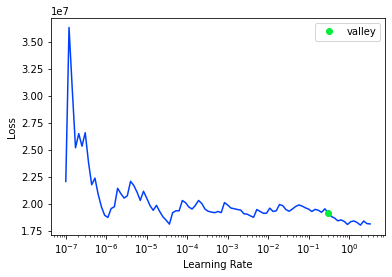

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   48.07      38.09
1  656.13    1843.07
2 1467.59    3188.74
3  368.58     475.44
4  112.59     109.26
XGBoost RMSE:  2564.4717


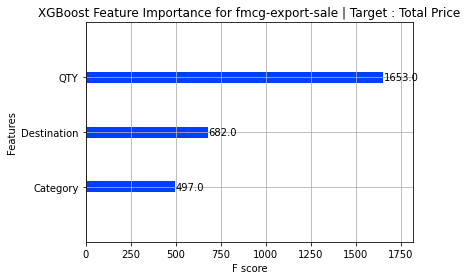

Target Variable: QTY
CATS=====================
['Category', 'Destination']
CONTS=====================
['Total Price']
3
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Total Price']
Categorical variables that made the cut : ['Category', 'Destination']
Tabular Object size: 1232


  2%|▏         | 1/42 [00:00<00:04,  9.92it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7394174024692757, 'Adjusted R-Squared': 0.7361870396899692, 'RMSE': 343.9500808371906, 'Time taken': 0.10037064552307129}
{'Model': 'BaggingRegressor', 'R-Squared': 0.861552005016629, 'Adjusted R-Squared': 0.8598357075581574, 'RMSE': 250.70676138319848, 'Time taken': 0.03904318809509277}
{'Model': 'BayesianRidge', 'R-Squared': 0.5961817462051033, 'Adjusted R-Squared': 0.5911757347944228, 'RMSE': 428.1694574955793, 'Time taken': 0.01005697250366211}


 17%|█▋        | 7/42 [00:00<00:00, 38.42it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8226904697615305, 'Adjusted R-Squared': 0.8204924177337809, 'RMSE': 283.7192159441002, 'Time taken': 0.01194310188293457}
{'Model': 'DummyRegressor', 'R-Squared': -0.003121019215598597, 'Adjusted R-Squared': -0.015556403751329162, 'RMSE': 674.8377623883848, 'Time taken': 0.009752750396728516}
{'Model': 'ElasticNet', 'R-Squared': 0.5093237496942197, 'Adjusted R-Squared': 0.5032409862606769, 'RMSE': 471.97635, 'Time taken': 0.010900497436523438}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (1,2) we computed -201.24734497070312 but the user-supplied value was -201.24737548828125.
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8060716472391735, 'Adjusted R-Squared': 0.8036675767504029, 'RMSE': 296.7176397243299, 'Time taken': 0.009905338287353516}


 26%|██▌       | 11/42 [00:00<00:01, 18.85it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.8272794900539937, 'Adjusted R-Squared': 0.8251383267075556, 'RMSE': 280.0236209999638, 'Time taken': 0.18620824813842773}
{'Model': 'GammaRegressor', 'R-Squared': 0.4161084429158798, 'Adjusted R-Squared': 0.40887011782806004, 'RMSE': 514.8595931506035, 'Time taken': 0.012413263320922852}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -17935.638083518847, 'Adjusted R-Squared': -18157.99310108313, 'RMSE': 90238.78392392909, 'Time taken': 0.12876653671264648}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8725398653050311, 'Adjusted R-Squared': 0.8709597809906306, 'RMSE': 240.5525128420025, 'Time taken': 0.14392423629760742}


 40%|████      | 17/42 [00:01<00:01, 13.41it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.8160554549792775, 'Adjusted R-Squared': 0.8137751507021611, 'RMSE': 288.97892287244616, 'Time taken': 0.3548285961151123}
{'Model': 'HuberRegressor', 'R-Squared': 0.5471651091003294, 'Adjusted R-Squared': 0.5415514534280195, 'RMSE': 453.41162660644227, 'Time taken': 0.018105745315551758}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.846174715927975, 'Adjusted R-Squared': 0.8442677909188177, 'RMSE': 264.26312983202536, 'Time taken': 0.010531187057495117}
{'Model': 'KernelRidge', 'R-Squared': 0.24061571165713613, 'Adjusted R-Squared': 0.23120185684296835, 'RMSE': 587.156, 'Time taken': 0.06485533714294434}
{'Model': 'Lars', 'R-Squared': 0.5964802735962942, 'Adjusted R-Squared': 0.591477962938397, 'RMSE': 428.01117, 'Time taken': 0.03157353401184082}
{'Model': 'LarsCV', 'R-Squared': 0.5964802735962942, 'Adjusted R-Squared': 0.591477962938397, 'RMSE': 428.01117, 'Time taken': 0.06073880195617676}


 48%|████▊     | 20/42 [00:01<00:01, 16.04it/s]

{'Model': 'Lasso', 'R-Squared': 0.5963160557636693, 'Adjusted R-Squared': 0.5913117093475164, 'RMSE': 428.09824, 'Time taken': 0.020704984664916992}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (1,2) we computed -201.24734497070312 but the user-supplied value was -201.24737548828125.
{'Model': 'LassoLars', 'R-Squared': 0.5862921161601438, 'Adjusted R-Squared': 0.5811635060298976, 'RMSE': 433.38074, 'Time taken': 0.009347915649414062}
{'Model': 'LassoLarsCV', 'R-Squared': 0.5964802735962942, 'Adjusted R-Squared': 0.591477962938397, 'RMSE': 428.01117, 'Time taken': 0.01583552360534668}
{'Model': 'LassoLarsIC', 'R-Squared': 0.5964802735962942, 'Adjusted R-Squared': 0.591477962938397, 'RMSE': 428.01117, 'Time taken': 0.014632701873779297}
{'Model': 'LinearRegression', 'R-Squared': 0.5964802732101997, 'Adjusted R-Squared': 0.5914779625475162

 67%|██████▋   | 28/42 [00:03<00:01,  7.04it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.2897484831399886, 'Adjusted R-Squared': 0.28094371226982306, 'RMSE': 567.8437, 'Time taken': 1.5319433212280273}
{'Model': 'NuSVR', 'R-Squared': 0.038082258310284556, 'Adjusted R-Squared': 0.026157658206693024, 'RMSE': 660.8329341021899, 'Time taken': 0.12884211540222168}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.5570325230951847, 'Adjusted R-Squared': 0.5515411907368606, 'RMSE': 448.44442774342315, 'Time taken': 0.009230852127075195}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.5964803001299714, 'Adjusted R-Squared': 0.5914779898010041, 'RMSE': 428.0111495105551, 'Time taken': 0.015558958053588867}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.5296855356355821, 'Adjusted R-Squared': 0.5238551910360232, 'RMSE': 462.07968892009416, 'Time taken': 0.009809494018554688}
{'Model': 'PoissonRegressor', 'R-Squared': 0.5075706721391495, 'Adjusted R-Squared': 0.5014661763392216, 'RMSE': 472.818724056278, 'Time taken': 0.011

 76%|███████▌  | 32/42 [00:27<00:21,  2.16s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.133373257654942, 'Adjusted R-Squared': -0.1474233393614084, 'RMSE': 717.3138097354499, 'Time taken': 23.957985639572144}
{'Model': 'RANSACRegressor', 'R-Squared': 0.4994950644541043, 'Adjusted R-Squared': 0.4932904578151056, 'RMSE': 476.67996, 'Time taken': 0.09230732917785645}


 90%|█████████ | 38/42 [00:27<00:04,  1.14s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.854615422295692, 'Adjusted R-Squared': 0.8528131341423328, 'RMSE': 256.9105157987085, 'Time taken': 0.2775254249572754}
{'Model': 'Ridge', 'R-Squared': 0.5963361334750585, 'Adjusted R-Squared': 0.5913320359561542, 'RMSE': 428.0876, 'Time taken': 0.010504722595214844}
{'Model': 'RidgeCV', 'R-Squared': 0.5950212592912134, 'Adjusted R-Squared': 0.590000861679121, 'RMSE': 428.7842496384427, 'Time taken': 0.009737968444824219}
{'Model': 'SGDRegressor', 'R-Squared': 0.5937023242442268, 'Adjusted R-Squared': 0.5886655761976676, 'RMSE': 429.4819144839375, 'Time taken': 0.010257720947265625}
{'Model': 'SVR', 'R-Squared': -0.010010178044205231, 'Adjusted R-Squared': -0.022530965375331835, 'RMSE': 677.1510972744712, 'Time taken': 0.07409977912902832}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.5964802732101997, 'Adjusted R-Squared': 0.5914779625475162, 'RMSE': 428.0112, 'Time taken': 0.010718345642089844}
{'Model': 'TweedieRegressor', '

100%|██████████| 42/42 [00:28<00:00,  1.50it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.8346900341683052, 'Adjusted R-Squared': 0.8326407370712181, 'RMSE': 273.9506, 'Time taken': 0.4555783271789551}
{'Model': 'LGBMRegressor', 'R-Squared': 0.7960217002703036, 'Adjusted R-Squared': 0.7934930436620842, 'RMSE': 304.3089286750704, 'Time taken': 0.10363531112670898}
Project: fmcg-export-sale
fmcg-export-sale
Target: QTY
QTY
Target Standard Deviation: 719.4199338345321
                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
GradientBoostingRegressor                    0.87       0.87   240.55   
BaggingRegressor                             0.86       0.86   250.71   
RandomForestRegressor                        0.85       0.85   256.91   
KNeighborsRegressor                          0.84       0.85   264.26   
XGBRegressor                                 0.83       0.83   273.95   
ExtraTreesRegressor                          0.83       0.83   280.0

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,649886.625000,567504.625000,753.329041,00:00
1,621914.187500,358384.125000,598.651917,00:00
2,521365.500000,1766085.375000,1328.941406,00:00


Better model found at epoch 0 with _rmse value: 753.3290405273438.
Better model found at epoch 1 with _rmse value: 598.6519165039062.
No improvement since epoch 1: early stopping


,Category,Destination,Total Price,QTY,QTY_pred
0,3.00,9.00,-0.40,150.00,30.26
1,6.00,2.00,-0.56,2.00,35.11
2,7.00,3.00,-0.02,900.00,114.79
3,4.00,9.00,-0.34,150.00,30.08
4,8.00,14.00,-0.32,70.00,38.33
5,7.00,2.00,0.39,600.00,209.03
6,4.00,9.00,-0.43,50.00,29.88
7,8.00,9.00,-0.29,75.00,32.21
8,7.00,9.00,2.10,4700.00,699.96


<Figure size 432x288 with 0 Axes>

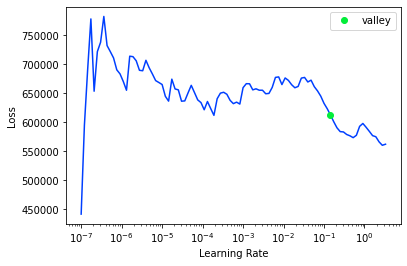

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0    1750     743.60
1     750     310.74
2       1       1.02
3      10      14.63
4      50      68.63
XGBoost RMSE:  273.95203


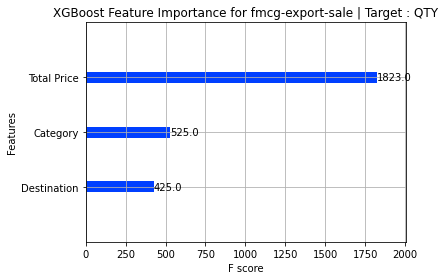

Target Variable: Destination
CATS=====================
['Category']
CONTS=====================
['QTY', 'Total Price']
3
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['QTY', 'Total Price']
Categorical variables that made the cut : ['Category']
Tabular Object size: 1231


  0%|          | 0/42 [00:00<?, ?it/s]

AdaBoostRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BaggingRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
BayesianRidge model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DecisionTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
DummyRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNet model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ElasticNetCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreeRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
ExtraTreesRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype

 86%|████████▌ | 36/42 [00:00<00:00, 175.12it/s]

Lars model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
LarsCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
Lasso model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
LassoCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
LassoLars model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
LassoLarsCV model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
LassoLarsIC model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
LinearRegression model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
LinearSVR model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
MLPRegressor model failed to execute
Input contai

100%|██████████| 42/42 [00:00<00:00, 168.56it/s]

SGDRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
SVR model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TransformedTargetRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
TweedieRegressor model failed to execute
Input contains NaN, infinity or a value too large for dtype('float64').
XGBRegressor model failed to execute
[18:09:16] ../src/data/data.cc:458: Check failed: valid: Label contains NaN, infinity or a value too large.
Stack trace:
  [bt] (0) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x16b9c9) [0x7f51a293e9c9]
  [bt] (1) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x178eb6) [0x7f51a294beb6]
  [bt] (2) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x179d10) [0x7f51a294cd10]
  [bt] (3) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(XGDMatrix

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time


Could not fit model
XGBoost failed


Traceback (most recent call last):
  File "/tmp/ipykernel_19/2755408106.py", line 281, in <module>
    learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
  File "/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py", line 119, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 256, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 245, in _do_fit
    self._with_events(self._do_epoch, 'epoch', CancelEpochException)
  File "/opt/conda/lib/python3.7/site-packages/fastai/learner.py", line 193, in _with_events
    try: self(f'before_{event_type}');  f()
  File "/opt/conda/lib/python3.7/site-pa

<Figure size 432x288 with 0 Axes>

In [23]:
target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].apply(pd.to_numeric, errors='coerce').dropna()
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].apply(pd.to_numeric, errors='coerce').dropna()

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

       feature  importance
0     Category      525.00
1  Destination      425.00
2  Total Price     1823.00
0     Category      497.00
1  Destination      682.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

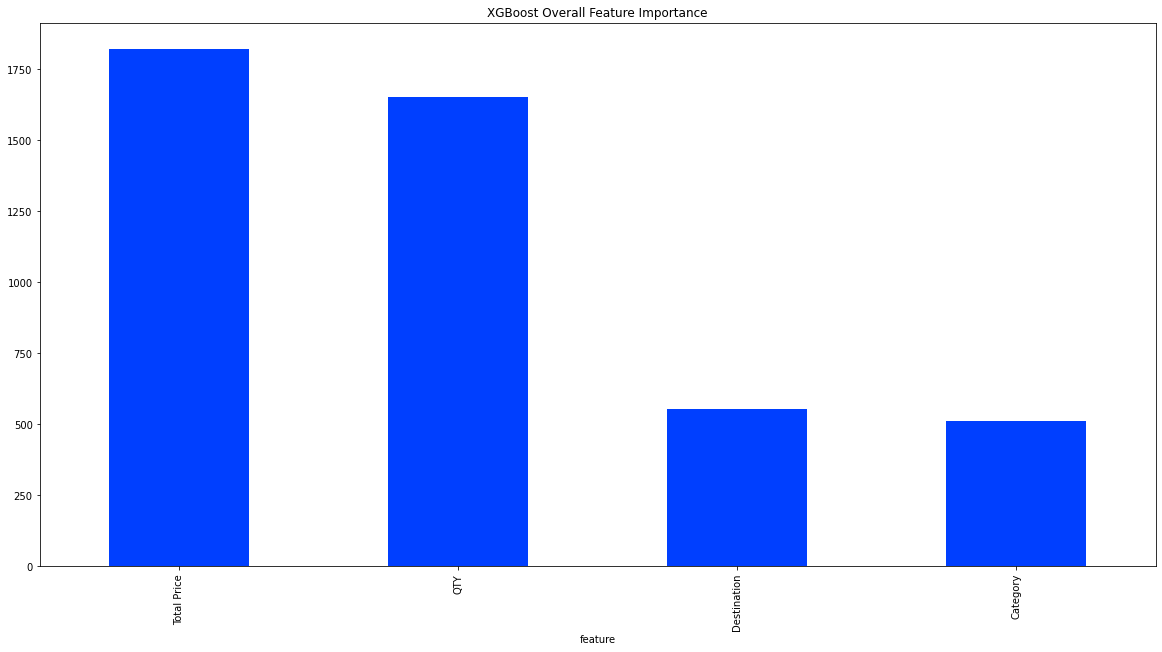

In [24]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [25]:
df.isna().sum()

Category          0
Destination    1231
QTY               0
Total Price       0
dtype: int64

# **To Be Continued...**